In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
pip install scienceplots

In [14]:
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_normal_float32
import numpy as np
from scipy.stats import norm
from scipy.stats.qmc import Halton
from dataclasses import dataclass
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["grid", "science", "no-latex"])

# I. Monte carlo estimation of Asian option prices:
The black scholes model for the spot price under risk neutral measure is:
$$dS_t = rS_t\,dt + \sigma S_t\,dW(t)$$
Which is equivalent to:
$$d\log(S_t) = \left(r - \frac{\sigma^2}{2}\right)\,dt + \sigma\,dW(t)$$
The corresponding Euler-Maruyama scheme for a discrete grid $\{t_k = \frac{kT}{n},\; k\in\{0,...,n\}\}$ is:
$$d\log(S_{t_{k+1}})  = d\log(S_{t_k}) + \left(r - \frac{\sigma^2}{2}\right)\frac{T}{n} + \sigma \sqrt\frac{T}{n} Z_{k+1}$$
Where $Z$ are i.i.d standard normal variables.
We aim to compute the price of an asian call:
$$\text{AsianCall}\left(S_t, \frac{1}{t}\int_{0}^{t}S_u\,du\right) = e^{-r(T-t)}\mathbb E\left[\left(\frac{1}{T}\int_{0}^{T}S_u\,du - K\right)^+\Bigg| \,S_t,\,\frac{1}{t}\int_{0}^{t}S_u\,du\right]$$
For convenience We will compute :
$$e^{-r(T-t)}\mathbb E\left[\left(\int_{0}^{T}S_u\,du - K\right)^+\Bigg| \,S_t,\,\int_{0}^{t}S_u\,du\right]$$
Which amounts to including the maturity in the strike and thus we only require the time to maturity parameter and not the maturity of the contract and the time to maturity.

In [3]:
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-3b309288-69ba-7554-274a-1742ca2569b6
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [4]:
# specifying the model
vol = 0.3
r = 0.1

In [5]:
import math

@cuda.jit
def generate_increments_kernel(rng_states, r, step, vol, out):
    thread_id = cuda.grid(1)
    if thread_id < out.shape[0]:
        out[thread_id] = xoroshiro128p_normal_float32(rng_states, thread_id)*vol*math.sqrt(step) + (r - 0.5*vol**2)*step


@dataclass
class BlackScholes:
    vol: float
    r: float

    def euler_scheme(self, spot: float, ttm: float, nb_paths: int, nb_steps: int) -> np.ndarray:
        """Sample nb_paths trajectories of the log spot
        Args:
            - spot: initial value of the asset
            - ttm: time to maturity
            - nb_paths: number of trajectories
            - nb_steps: number of discretization steps
        Returns:
            - np.ndarray: two dimensional array with a trajectory per row
        """
        # Initialize a state for each thread
        rng_states = create_xoroshiro128p_states(nb_steps * nb_paths, seed=42)
        # Initialize an empty array
        sample_paths = cuda.device_array(nb_steps * nb_paths, dtype=np.float32)
        # Generate the random increments
        generate_increments_kernel[nb_paths, nb_steps](rng_states, self.r, ttm/nb_steps, self.vol, sample_paths)
        sample_paths = sample_paths.copy_to_host()
        sample_paths = sample_paths.reshape((nb_paths, nb_steps))
        sample_paths = sample_paths.cumsum(axis=1)
        sample_paths = spot * np.exp(sample_paths)

        return sample_paths

    def call(self, spot: float, ttm: float, strike: float) -> float:
        """Compute BlackScholes price of a call option using closed formula
        Args:
            - spot: initial value of the asset
            - ttm: time to maturity
            - strike: strike of the contract
        Returns:
            - float: price of the call option
        """
        moneyness = np.exp(self.r*ttm)*spot / strike
        d1 = np.log(moneyness) / (np.sqrt(ttm)*self.vol) + 0.5 * self.vol * np.sqrt(ttm)
        d2 = d1 - self.vol * np.sqrt(ttm)
        return spot*norm.cdf(d1) - np.exp(-self.r*ttm)*strike*norm.cdf(d2)

    def put(self, spot: float, ttm: float, strike: float) -> float:
        """Compute BlackScholes price of a put option using call put parity
        Args:
            - spot: initial value of the asset
            - ttm: time to maturity
            - strike: strike of the contract
        Returns:
            - float: price of the put option
        """
        return self.call(spot, ttm, strike) - spot + np.exp(-self.r*ttm)*strike

    def sample_call_payoff(self, spot: float, ttm: float, strike: float, nb_paths: int, nb_steps: int) -> np.ndarray:
        """Sample call option payoff using euler scheme
        Args:
            - spot: initial value of the asset
            - ttm: time to maturity
            - strike: strike of the contract
            - nb_paths: number of discretized trajectories
            - nb_steps: number of steps of each trajectory
        Returns:
            - float: price of the put option
        """
        sample_paths = self.euler_scheme(spot, ttm, nb_paths, nb_steps)
        return np.exp(-self.r*ttm) * np.maximum(sample_paths[:,-1] - strike, 0)

    def sample_put_payoff(self, spot: float, ttm: float, strike: float, nb_paths: int, nb_steps: int) -> np.ndarray:
        """Sample put option payoff using euler scheme
        Args:
            - spot: initial value of the asset
            - ttm: time to maturity
            - strike: strike of the contract
            - nb_paths: number of discretized trajectories
            - nb_steps: number of steps of each trajectory
        Returns:
            - float: price of the put option
        """
        sample_paths = self.euler_scheme(spot, ttm, nb_paths, nb_steps)
        return np.exp(-self.r*ttm) * np.maximum(strike - sample_paths[:, -1], 0)

    def sample_asian_call_payoff(self, spot: float, path_integral: float, ttm: float, strike: float, nb_paths: int, nb_steps: int) -> np.ndarray:
        """Sample asian call option payoff in the simplified form described above using euler scheme
        Args:
            - spot: initial value of the asset
            - path_integral: integral of the asset up until the evaluation instant t
            - ttm: time to maturity
            - strike: strike of the contract
            - nb_paths: number of discretized trajectories
            - nb_steps: number of steps of each trajectory
        Returns:
            - float: price of the asian call option
        """
        sample_paths = self.euler_scheme(spot, ttm, nb_paths, nb_steps)
        full_integral = path_integral + ttm*np.mean(sample_paths, axis=1)
        return np.exp(-self.r*ttm) * np.maximum(full_integral - strike, 0)

    def sample_asian_put_payoff(self, spot: float, path_integral: float, ttm: float, strike: float, nb_paths: int, nb_steps: int) -> np.ndarray:
        """Sample asian put option payoff in the simplified form described above using euler scheme
        Args:
            - spot: initial value of the asset
            - path_integral: integral of the asset up until the evaluation instant t
            - ttm: time to maturity
            - strike: strike of the contract
            - nb_paths: number of discretized trajectories
            - nb_steps: number of steps of each trajectory
        Returns:
            - float: price of the asian call option
        """
        sample_paths = self.euler_scheme(spot, ttm, nb_paths, nb_steps)
        full_integral = path_integral + ttm*np.mean(sample_paths, axis=1)
        return np.exp(-self.r*ttm) * np.maximum(strike - full_integral, 0)

    def mc_estimator(self, payoff: np.ndarray) -> tuple[float, float]:
        """Compute monte carlo estimator and corresponding variance
        Args:
            - payoff: array of i.i.d instances of the payoff to compute
        Returns:
            - typle[float, float]: monte carlo estimator and corresponding variance
        """
        return payoff.mean(), payoff.var()



In [15]:
diffusion = BlackScholes(vol, r)
diffusion

BlackScholes(vol=0.3, r=0.1)

In [16]:
nb_paths_list = [2**k for k in range(10, 20)]
nb_steps = 128
call_mc_results = np.zeros((len(nb_paths_list), 2))
put_mc_results = np.zeros((len(nb_paths_list), 2))
spot = 100
call_strike = 90
put_strike = 120
ttm = 1

call_baseline = diffusion.call(spot, ttm, call_strike)
put_baseline = diffusion.put(spot, ttm, put_strike)

for i, nb_paths in enumerate(nb_paths_list):
    sample_call_payoff = diffusion.sample_call_payoff(spot, ttm, call_strike, nb_paths, nb_steps)
    call_mc_results[i, :] = diffusion.mc_estimator(sample_call_payoff)
    call_mc_results[i, 1] = np.sqrt(call_mc_results[i, 1] / nb_paths)

    sample_put_payoff = diffusion.sample_put_payoff(spot, ttm, put_strike, nb_paths, nb_steps)
    put_mc_results[i, :] = diffusion.mc_estimator(sample_put_payoff)
    put_mc_results[i, 1] = np.sqrt(put_mc_results[i, 1] / nb_paths)

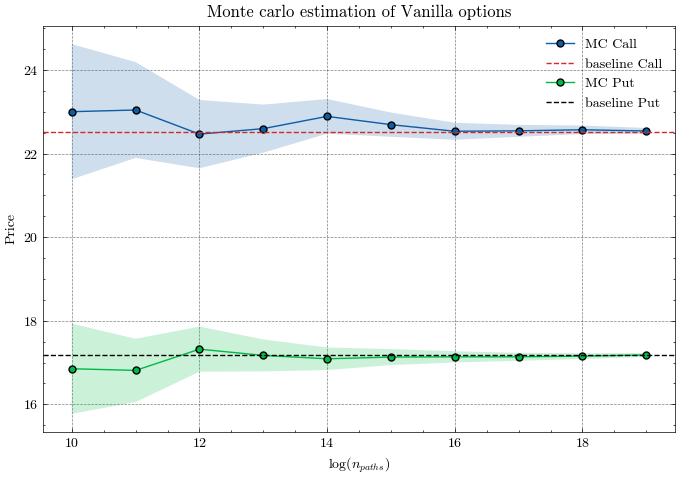

In [22]:
fig = plt.figure(figsize=(7, 5))

plt.plot(range(10, 20), call_mc_results[:, 0], marker="o", ms=5, mec="k", label="MC Call")
plt.fill_between(range(10, 20), call_mc_results[:, 0] - norm.ppf(1 - 0.05/2)*call_mc_results[:, 1], call_mc_results[:, 0] + norm.ppf(1 - 0.05/2)*call_mc_results[:, 1], alpha=0.2)

plt.axhline(call_baseline, linestyle="--", label="baseline Call", color="tab:red")

plt.plot(range(10, 20), put_mc_results[:, 0], marker="o", ms=5, mec="k", label="MC Put")
plt.fill_between(range(10, 20), put_mc_results[:, 0] - norm.ppf(1 - 0.05/2)*put_mc_results[:, 1], put_mc_results[:, 0] + norm.ppf(1 - 0.05/2)*put_mc_results[:, 1], alpha=0.2)

plt.axhline(put_baseline, linestyle="--", label="baseline Put", color="black")

plt.title("Monte carlo estimation of Vanilla options")
plt.xlabel(r"$\log(n_{paths})$")
plt.ylabel("Price")
plt.legend(fancybox=True, edgecolor="k", loc=0)

fig.tight_layout()
plt.show()
plt.close()

# II. Learning Asian option prices via neural networks:

We aim to learn the following function:
$$f\left(S_t,\int_{0}^{t}S_u\,du, T-t, K, \sigma, r\right) = e^{-r(T-t)}\mathbb E\left[\left(\int_{0}^{T}S_u\,du - K\right)^+\Bigg| \,S_t,\,\int_{0}^{t}S_u\,du\right]$$
We can further simplify it by normalizing everything with the strike we and thus we have one less parameter to learn.
$$f\left(\frac{S_t}{K},\int_{0}^{t}\frac{S_u}{K}\,du, T-t, \sigma, r\right) = e^{-r(T-t)}\mathbb E\left[\left(\int_{0}^{T}\frac{S_u}{K}\,du - 1\right)^+\Bigg| \,\frac{S_t}{K},\,\int_{0}^{t}\frac{S_u}{K}\,du\right]$$
The ratio $\frac{S}{K}$ is called moneyness and we will call it $m$. Ergo:
$$f\left(m_t,\int_{0}^{t}m_u\,du, T-t, \sigma, r\right) = e^{-r(T-t)}\mathbb E\left[\left(\int_{0}^{T}m_u\,du - 1\right)^+\Bigg| \,m_t,\,\int_{0}^{t}m_u\,du\right]$$
We need to specify a grid of values for our parameters.

| Parameter | Interval |
| :-: | --- |
| $m_t$| [0.8, 1.2] |
| $\int_{0}^{t}m_u\,du$| [0.8, 1.2] |
| $T-t$| [0.2, 1] |
| $\sigma$| [0.1, 0.5] |
| $r$| [0, 0.1] |

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import tqdm
from collections import deque

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, depth, hidden_dim, activation=nn.SiLU(), normalization=None):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(depth-1)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = activation
        if normalization == "batch":
            self.normalization = nn.BatchNorm1d(hidden_dim)
        elif normalization == "layer":
            self.normalization = nn.LayerNorm(hidden_dim)
        else:
            self.normalization = None

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
            if self.normalization is not None:
                x = self.normalization(x)
        return nn.functional.ReLU(self.output_layer(x)) # We run the last layer through a relu since price is positive

# Training loop
def train(model, optimizer, scheduler, loss_fn, train_loader, valid_loader, epochs=100, eval_freq=5, checkpoint=True):
    training_loss = deque()
    validation_loss = deque()
    best_validation_loss = float("inf")
    desc = "Training Loop"
    with tqdm.tqdm(total=epochs, desc=desc, position=0, leave=True) as progress_bar:
        for epoch in range(epochs):
            # Gradient descent over train dataloader
            train_loss = 0
            model.train()
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss
            train_loss = train_loss / len(train_loader)
            training_loss.append(train_loss) # Saving result

            # Model evaluation
            if epoch % eval_freq == 0:
                valid_loss = 0
                model.eval()
                with torch.no_grad():
                    for inputs, targets in valid_loader:
                        inputs = inputs.to(device)
                        targets = targets.to(device)
                        outputs = model(inputs)
                        loss = loss_fn(outputs, targets)
                        valid_loss += loss
                valid_loss = valid_loss / len(valid_loader)
                validation_loss.append(valid_loss) # Saving result

                # Setting checkpoints
                if checkpoint and valid_loss < best_validation_loss:
                    best_validation_loss = valid_loss
                    torch.save(model.state_dict(), "checkpoint.pth")

            # Training logs
            logs = f"Epoch {epoch}: lr = {scheduler.get_last_lr():.5f}, training_loss = {train_loss}, best_validation_loss = {best_validation_loss}"
            progress_bar.update(1)
            progress_bar.set_description(logs)
            print(logs)
            scheduler.step() # Incrementing scheduler

    return training_loss, validation_loss

In [ ]:
# Specifying the model and training hyperparameters
config = dict(input_dim=2,
              output_dim=1,
              hidden_dim=32,
              depth=4,
              batch_size=512,
              lr=1e-3,
              base_lr=1e-5,
              max_lr=1e-3,
              epochs=1000,
              eval_freq=25)
model = MLP(input_dim=config["input_dim"],
            output_dim=config["output_dim"],
            hidden_dim=config["hidden_dim"],
            depth=config["depth"],).to(device)
optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=config["base_lr"], max_lr=config["max_lr"], step_size_up=25, step_size_down=25
)

In [ ]:
learning_rate = []
for i in range(200):
    learning_rate.append(scheduler.get_last_lr())
    scheduler.step()

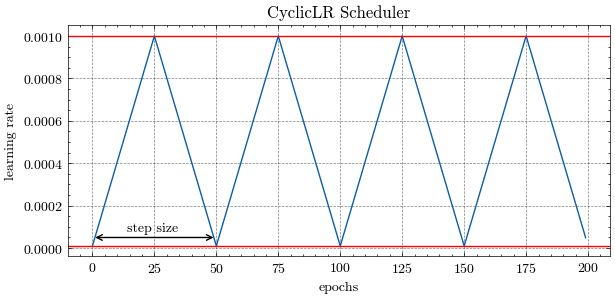

In [ ]:
# Display scheduler
fig = plt.figure(figsize=(7, 3))

plt.plot(
    np.arange(200),
    learning_rate,
)
plt.axhline(y=0.001, color="red")
plt.axhline(y=0.00001, color="red")
plt.annotate(
    text="", xy=(50, 0.00005), xytext=(0, 0.00005), arrowprops=dict(arrowstyle="<->")
)
plt.text(x=14, y=0.00008, s="step size")
plt.xlabel("epochs")
plt.ylabel("learning rate")
plt.title("CyclicLR Scheduler")
plt.show()
plt.close()